In [1]:
import os
import gc
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
# else: raise ValueError('Running on CPU is not recommended.')
else: print('Running on CPU')

Using GPU: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SyntaxSquad/
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1y5j_w0jTp2u2rRUY8iyzaI8Vpo5gPy7d/SyntaxSquad
datasets  pose2gloss  preprocessing  SyntaxSquad.ipynb


In [5]:
from collections import Counter
landmarks_dict = np.load('./datasets/WLASL_landmarks.npz', allow_pickle=True)

with open('./datasets/WLASL_parsed_metadata.json', 'r') as json_file:
    parsed_metadata = json.load(json_file)
    glosses_counts = dict(Counter(item['gloss'] for item in parsed_metadata).most_common())
print(glosses_counts)

{'book': 40, 'drink': 35, 'computer': 30, 'before': 26, 'chair': 26, 'go': 26, 'clothes': 25, 'who': 25, 'candy': 24, 'cousin': 23, 'deaf': 23, 'fine': 22, 'help': 22, 'no': 22, 'thin': 22, 'walk': 22, 'year': 22, 'yes': 22, 'all': 21, 'black': 21, 'cool': 21, 'finish': 21, 'hot': 21, 'like': 21, 'many': 21, 'mother': 21, 'now': 21, 'orange': 21, 'table': 21, 'thanksgiving': 21, 'what': 21, 'woman': 21, 'bed': 20, 'blue': 20, 'bowling': 20, 'can': 20, 'dog': 20, 'family': 20, 'fish': 20, 'graduate': 20, 'hat': 20, 'hearing': 20, 'kiss': 20, 'language': 20, 'later': 20, 'man': 20, 'shirt': 20, 'study': 20, 'tall': 20, 'white': 20, 'wrong': 20, 'accident': 19, 'apple': 19, 'bird': 19, 'change': 19, 'color': 19, 'corn': 19, 'cow': 19, 'dance': 19, 'dark': 19, 'doctor': 19, 'eat': 19, 'enjoy': 19, 'forget': 19, 'give': 19, 'last': 19, 'meet': 19, 'pink': 19, 'pizza': 19, 'play': 19, 'school': 19, 'secretary': 19, 'short': 19, 'time': 19, 'want': 19, 'work': 19, 'africa': 18, 'basketball': 

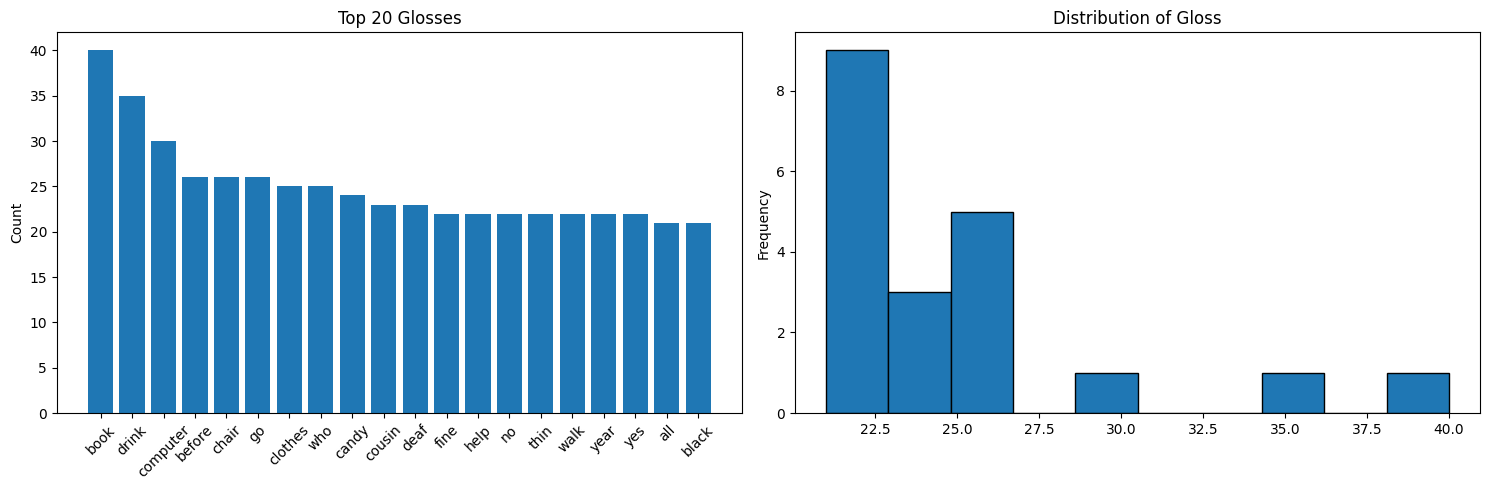

In [6]:
top_n = 20
glosses = list(glosses_counts.keys())[:top_n]
counts = list(glosses_counts.values())[:top_n]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(glosses, counts)
plt.ylabel('Count')
plt.title('Top 20 Glosses')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(counts, edgecolor='black')
plt.ylabel('Frequency')
plt.title('Distribution of Gloss')
plt.tight_layout()
plt.show()

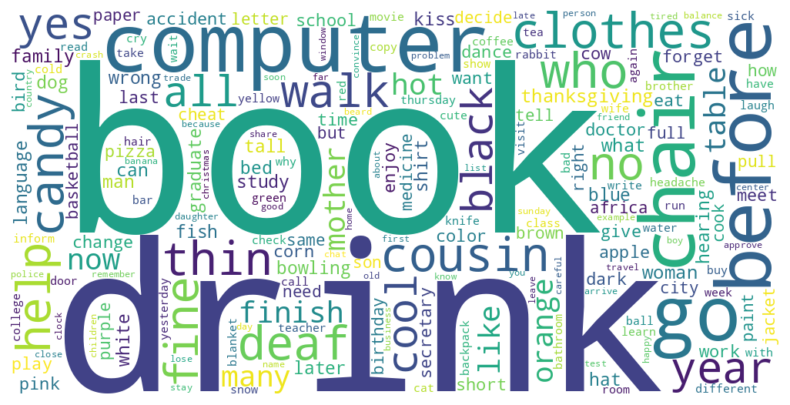

In [7]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(glosses_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Choose Daily Related Words

In [ ]:
# import gzip
# import shutil
# with gzip.open('cc.en.300.bin.gz', 'rb') as f_in:
#     with open('/tmp/cc.en.300.bin', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

In [ ]:
# # !pip install -q fasttext
# !pip install -q fasttext-wheel # Try this if the above shows errors
# import fasttext
# import fasttext.util
# # fasttext.util.download_model('en', if_exists='ignore')
# ft = fasttext.load_model('/tmp/cc.en.300.bin')

In [ ]:
# daily_words = [
#     'hello', 'goodbye', 'thank you', 'sorry', 'yes', 'no', 'stop', 'go',
#     'left', 'right', 'ahead', 'around', 'help', 'address', 'destination',
#     'time', 'money', 'cost', 'lost', 'map', 'street', 'road'
# ]
# labels_dict = {label: ft.get_word_vector(label) for label in glosses_counts}
# daily_vectors = [ft.get_word_vector(word) for word in daily_words]

In [ ]:
# from scipy.spatial.distance import cosine
# threshold = 0.5
# similar_words_set = set()

# for label, label_vector in labels_dict.items():
#     for daily_vector in daily_vectors:
#         similarity_score = 1 - cosine(daily_vector, label_vector)
#         if similarity_score > threshold:
#             similar_words_set.add(label)

# similar_words_list = list(similar_words_set)
# len(similar_words_list)

# Data Splitting

In [ ]:
# For the new *.npz with metadata information
# def load_subset(split, chosen_landmarks=None, chosen_labels=None, max_labels=None, max_samples=None):
#     if chosen_landmarks is None: landmarks = list(range(landmarks_dict[0].shape[1]))
#     X, y = [], []
#     for idx, item in tqdm(landmarks_dict.items()):
#         if item['split'] != split or \
#            (max_samples and idx >= max_samples) or \
#            (chosen_labels and item['gloss'] not in chosen_labels) or \
#            (max_labels and item['gloss'] not in list(label_counts.keys())[:max_labels]):
#             continue
#         X.append(item['landmarks'][:, chosen_landmarks, :])
#         y.append(item['gloss'])
#     return X, y

In [8]:
def load_subset(split, chosen_landmarks=None, chosen_labels=None, max_labels=None, max_samples=None):
    chosen_landmarks = chosen_landmarks or list(range(landmarks_dict['0'].shape[1]))
    if max_labels: chosen_labels = set(list(glosses_counts.keys())[:max_labels])
    elif chosen_labels: chosen_labels = set(chosen_labels)
    X, y = [], []

    for k, landmarks in tqdm(landmarks_dict.items(), desc=f'Splitting {split} subset'):
        meta = parsed_metadata[int(k)]
        if meta['split'] != split: continue
        if chosen_labels is None or meta['gloss'] in chosen_labels:
            X.append(landmarks[:, chosen_landmarks, :])
            y.append(meta['gloss'])
    return (X[:max_samples], y[:max_samples]) if max_samples else (X, y)

In [9]:
# X_train, y_train = load_subset('train', chosen_labels=similar_words_list)
# X_val, y_val = load_subset('val', chosen_labels=similar_words_list)
# X_test, y_test = load_subset('test', chosen_labels=similar_words_list)
X_train, y_train = load_subset('train', max_labels=100)
X_val, y_val = load_subset('val', max_labels=100)
X_test, y_test = load_subset('test', max_labels=100)

print('First video has', len(X_train[0]), 'frames with', len(X_train[0][0]), 'landmarks')
del landmarks_dict, parsed_metadata
gc.collect()

Splitting train subset:   0%|          | 0/21083 [00:00<?, ?it/s]

Splitting val subset:   0%|          | 0/21083 [00:00<?, ?it/s]

Splitting test subset:   0%|          | 0/21083 [00:00<?, ?it/s]

First video has 72 frames with 180 landmarks


10295

### Statistics Summary

In [10]:
def subset_statistics(X, y, subset_name='Subset'):
    num_videos, num_classes = len(X), len(np.unique(y))
    avg_frames_per_video, avg_landmarks_per_frame = 0, 0
    if num_videos > 0:
        avg_frames_per_video = np.mean([len(video) for video in X])
        avg_landmarks_per_frame = np.mean([len(video[0]) for video in X if len(video) > 0])

    return pd.DataFrame({
        'Subset': [subset_name],
        'Number of Videos': [num_videos],
        'Number of Classes': [num_classes],
        'Average Frames/Video': [avg_frames_per_video],
        'Number of Landmarks/Frame': [avg_landmarks_per_frame]
    })

In [11]:
# Compute high-level statistics
train_stats = subset_statistics(X_train, y_train, 'Train')
val_stats = subset_statistics(X_val, y_val, 'Validation')
test_stats = subset_statistics(X_test, y_test, 'Test')
subset_summary = pd.concat([train_stats, val_stats, test_stats], ignore_index=True)

# Create detailed statistics DataFrame
train_details = pd.DataFrame({
    'Subset': ['Train'] * len(X_train),
    'Gloss': y_train,
    'Video Length': [len(video) for video in X_train],
    'Frame Landmarks': [len(video[0]) for video in X_train]
})

val_details = pd.DataFrame({
    'Subset': ['Validation'] * len(X_val),
    'Gloss': y_val,
    'Video Length': [len(video) for video in X_val],
    'Frame Landmarks': [len(video[0]) for video in X_val]
})

test_details = pd.DataFrame({
    'Subset': ['Test'] * len(X_test),
    'Gloss': y_test,
    'Video Length': [len(video) for video in X_test],
    'Frame Landmarks': [len(video[0]) for video in X_test]
})

In [12]:
# Combine descriptive statistics
combined_details = pd.concat([train_details, val_details, test_details], ignore_index=True)
detailed_stats = combined_details.groupby('Subset').agg({
    'Video Length': ['mean', 'std', 'min', 'max'],
    # 'Frame Landmarks': ['mean', 'std', 'min', 'max']
}).reset_index()

# Merge high-level and detailed statistics
detailed_stats.columns = ['Subset'] + [f"{col[0]} ({col[1]})" for col in detailed_stats.columns[1:]]
final_stats = pd.merge(subset_summary, detailed_stats, on='Subset')
final_stats

,Subset,Number of Videos,Number of Classes,Average Frames/Video,Number of Landmarks/Frame,Video Length (mean),Video Length (std),Video Length (min),Video Length (max)
0,Train,1442,100,65.371012,180.0,65.371012,24.098723,13,195
1,Validation,338,100,66.760355,180.0,66.760355,25.395482,12,195
2,Test,258,100,62.461240,180.0,62.461240,24.186702,18,148


### Visualizations

In [13]:
import plotly.express as px
fig = px.histogram(combined_details, x='Video Length', color='Subset', barmode='overlay', nbins=20)
fig.update_layout(
    title='Distribution of Video Lengths for Each Subset',
    xaxis_title='Video Length',
    yaxis_title='Frequency',
    legend_title='Subset'
)
fig.show()

In [14]:
fig = px.box(combined_details, x='Subset', y='Video Length', color='Subset')
fig.update_layout(
    title='Video Length Distribution by Set',
    xaxis_title='Subset',
    yaxis_title='Video Length (Frames)'
)

# Training Augmentation

In [15]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

In [16]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = ((
        data[non_zero[:, 0], non_zero[:, 1], :2] - center
    ) * factor + center)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))
    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]

### Apply Augmentation

In [17]:
def apply_augmentation(data):
    aug_funcs = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_funcs)
    count = 0
    for func in aug_funcs:
        if np.random.rand() < 0.5:
            data = func(data)
            count += 1
    if count == 0: data = apply_augmentation(data)
    return data

In [18]:
def augment(X, y, num=None):
    X_aug, y_aug = X.copy(), y.copy()
    for i in tqdm(range(len(y))):
        for _ in range(num or np.random.choice([1, 2, 3])):
            X_aug.append(apply_augmentation(X[i].copy()))
            y_aug.append(y[i])
    return X_aug, y_aug

In [ ]:
X_train, y_train = augment(X_train, y_train, num=1)
print('The Training set has', len(X_train), 'videos')
print('First video has', len(X_train[0]), 'frames')
print('Each frame has', len(X_train[0][0]), 'landmarks')
print('Each landmark has', len(X_train[0][0][0]), 'coordinates')
gc.collect()

  0%|          | 0/1442 [00:00<?, ?it/s]

The Training set has 2884 videos
First video has 72 frames
Each frame has 180 landmarks
Each landmark has 3 coordinates


38

### Test Augmentation

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# example_frame_landmarks = np.expand_dims(example_frame_landmarks, axis=0)
# for landmark in example_frame_landmarks[0]:
#     x = int(landmark[0] * img.shape[1])
#     y = int(landmark[1] * img.shape[0])
#     cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

# axs[0].set_title('Original Image')
# axs[0].imshow(img[:, :, ::-1])
# axs[0].axis('off')

# augmented_landmarks = apply_augmentation(example_frame_landmarks.copy())
# img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
# for landmark in augmented_landmarks[0]:
#     x = int(landmark[0] * img.shape[1])
#     y = int(landmark[1] * img.shape[0])
#     cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

# axs[1].set_title('Augmented Image')
# axs[1].imshow(img[:, :, ::-1])
# axs[1].axis('off')
# plt.tight_layout()
# plt.show()

# Prepare for Training

In [ ]:
filtered_hand = list(range(21))
filtered_pose = [11, 12, 13, 14, 15, 16]
filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

ALL_LANDMARKS = filtered_hand * 2 + filtered_pose + filtered_face
print('Total number of landmarks/video:', len(ALL_LANDMARKS))
print(f'The center of the nose ({ALL_LANDMARKS[49]}) is at index 49')
print(f'The left shoulder ({ALL_LANDMARKS[42]}) is at index 42')
print(f'The right shoulder ({ALL_LANDMARKS[43]}) is at index 43')

Total number of landmarks/video: 180
The center of the nose (4) is at index 49
The left shoulder (11) is at index 42
The right shoulder (12) is at index 43


In [ ]:
MAX_FRAMES = 195
PADDING_VALUE = -100.
BATCH_SIZE = 128
EPOCHS = 100
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
gc.collect() # Free space

19933

### Padding and Truncating

In [ ]:
def pad_or_truncate(X, y, max_frames=None, pad_value=0):
    if max_frames is None: max_frames = max(len(video_landmarks) for video_landmarks in X)
    X_padded = np.array([video_landmarks[:max_frames] if len(video_landmarks) > max_frames else np.pad(video_landmarks, (
        (0, max_frames - len(video_landmarks)), # 0 for no padding before existing frames, the other for padding needed to reach max_frames
        (0, 0), # Apply no padding to the 2nd dimension (landmarks)
        (0, 0)  # Apply no padding to the 3rd dimension (coordinates)
    ), mode='constant', constant_values=pad_value) for video_landmarks in tqdm(X)])
    return X_padded, y

In [ ]:
X_train, y_train = pad_or_truncate(X_train, y_train, max_frames=MAX_FRAMES, pad_value=PADDING_VALUE)
X_val, y_val = pad_or_truncate(X_val, y_val, max_frames=MAX_FRAMES, pad_value=PADDING_VALUE)
X_test, y_test = pad_or_truncate(X_test, y_test, max_frames=MAX_FRAMES, pad_value=PADDING_VALUE)
X_train.shape, X_val.shape, X_test.shape

  0%|          | 0/2884 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

((2884, 195, 180, 3), (338, 195, 180, 3), (258, 195, 180, 3))

### Label Encoding

In [ ]:
# y_train = np.array([labels_dict[label] for label in y_train])
# y_val = np.array([labels_dict[label] for label in y_val])
# y_test = np.array([labels_dict[label] for label in y_test])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

### Normalize (SImple but Important)

In [ ]:
def pose_based_normalize(video_landmarks, label, scale_by_shoulder=False):
    nose_center = video_landmarks[:, 49, :]
    translated_landmarks = video_landmarks - nose_center[:, None, :]

    if scale_by_shoulder: # Use the distance between left shoulder (42) and right shoulder (43)
        left_shoulder = video_landmarks[:, 42, :]
        right_shoulder = video_landmarks[:, 43, :]
        shoulder_distance = tf.norm(left_shoulder - right_shoulder, axis=-1, keepdims=True)
        shoulder_distance = tf.where(shoulder_distance == 0, tf.ones_like(shoulder_distance), shoulder_distance)
        return translated_landmarks / shoulder_distance[:, None, :], label
    return translated_landmarks, label # tf.one_hot(label, len(np.unique(y_train)))

### Make `tf.data.Dataset`

In [ ]:
def prepare_tf_dataset(X, y, batch_size=64, drop_remainder=False, shuffle=True, use_cache=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).map(pose_based_normalize, tf.data.AUTOTUNE)
    if shuffle: dataset = dataset.shuffle(len(X))
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)

    # When use .cache(), everything before is saved in the memory. It gives a
    # significant boost in speed but only if you can get your hands on a larger RAM
    if use_cache: dataset = dataset.cache()
    return dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
train_tf_dataset = prepare_tf_dataset(X_train, y_train, batch_size=BATCH_SIZE)
val_tf_dataset = prepare_tf_dataset(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
test_tf_dataset = prepare_tf_dataset(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
gc.collect()

120

# Model Development

In [ ]:
from tensorflow.keras.layers import (
    Conv1D, Dropout, ZeroPadding1D, DepthwiseConv1D, Dense, BatchNormalization,
    MultiHeadAttention, Reshape, Softmax, Permute, Add, Masking, GlobalAveragePooling1D
)
import tensorflow.keras.mixed_precision as mixed_precision
try: mixed_precision.set_global_policy(mixed_precision.Policy('mixed_bfloat16'))
except: mixed_precision.set_global_policy(mixed_precision.Policy('mixed_float16'))

tf.keras.backend.clear_session()
gc.collect()
tf.config.optimizer.set_jit(True)

### Define Model Components

In [ ]:
class EfficientChannelAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = Conv1D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)

    def call(self, inputs, mask=None):
        x = GlobalAveragePooling1D()(inputs, mask=mask)
        x = self.conv(tf.expand_dims(x, -1))
        x = tf.squeeze(x, -1)
        return inputs * tf.sigmoid(x)[:, None, :]


class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self,
        kernel_size=17, dilation_rate=1, use_bias=False,
        depthwise_initializer='glorot_uniform', name='', **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.causal_pad = ZeroPadding1D((dilation_rate * (kernel_size - 1), 0), name=name + '_pad')
        self.dw_conv = DepthwiseConv1D(
            kernel_size, strides=1, dilation_rate=dilation_rate, padding='valid', use_bias=use_bias,
            depthwise_initializer=depthwise_initializer, name=name + '_dwconv'
        )
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        return self.dw_conv(x)


def Conv1DBlock(
    channel_size, kernel_size, dilation_rate=1, drop_rate=0.2,
    expand_ratio=2, se_ratio=0.25, activation='swish', name=None
):
    if name is None: name = str(tf.keras.backend.get_uid('mbblock'))
    def apply(inputs): # Expansion phase
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio
        skip = inputs

        x = Dense(channels_expand, use_bias=True, activation=activation, name=name + '_expand_conv')(inputs)
        x = CausalDWConv1D(kernel_size, dilation_rate=dilation_rate, use_bias=False, name=name + '_dwconv')(x) # Depthwise Convolution
        x = BatchNormalization(momentum=0.95, name=name + '_bn')(x)
        x = EfficientChannelAttention()(x)
        x = Dense(channel_size, use_bias=True, name=name + '_project_conv')(x)
        x = Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)
        return tf.keras.layers.add([x, skip], name=name + '_add') if channels_in == channel_size else x
    return apply

In [ ]:
def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2):
    def apply(inputs):
        x = BatchNormalization(momentum=0.95)(inputs)
        x = MultiHeadAttention(key_dim=dim // num_heads, num_heads=num_heads, dropout=attn_dropout)(x, x)
        x = Dropout(drop_rate, noise_shape=(None, 1, 1))(x)
        x = Add()([inputs, x])
        attn_out = x

        x = BatchNormalization(momentum=0.95)(x)
        x = Dense(dim*expand, use_bias=False, activation='swish')(x)
        x = Dense(dim, use_bias=False)(x)
        x = Dropout(drop_rate, noise_shape=(None,1,1))(x)
        return Add()([attn_out, x])
    return apply


def Conv1DTransformerBlock(x, dim, kernel_size):
    x = Conv1DBlock(dim, kernel_size, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, kernel_size, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, kernel_size, drop_rate=0.2)(x)
    x = TransformerBlock(dim, expand=2)(x)

    x = Conv1DBlock(dim, kernel_size, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, kernel_size, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, kernel_size, drop_rate=0.2)(x)
    return TransformerBlock(dim, expand=2)(x)

### Build the Model

In [ ]:
def build_GISLR(dim=192, kernel_size=17, is_training=True):
    inputs = tf.keras.Input((MAX_FRAMES, len(ALL_LANDMARKS), 3)) # 180 landmarks with 3 coordinates
    x = Reshape((MAX_FRAMES, len(ALL_LANDMARKS) * 3))(inputs)

    if is_training: x = Masking(mask_value=PADDING_VALUE)(x)
    x = Dense(dim, use_bias=False,name='stem_conv')(x)
    x = BatchNormalization(momentum=0.95)(x)
    x = Conv1DTransformerBlock(x, dim, kernel_size)
    x = Dense(dim * 2, activation=None, name='top_conv')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(len(np.unique(y_train)), name='output')(x)
    return tf.keras.Model(inputs, x)

In [ ]:
model = build_GISLR()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 195, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 195, 540)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_4 (Masking)       │ (None, 195, 540)       │              0 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 195, 540)       │              0 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Dense)         │ (None, 195, 192)       │        103,680 │ masking_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_4 (Any)               │ (None, 195)            │              0 │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 195, 192)       │            768 │ stem_conv[0][0],       │
│ (BatchNormalization)      │                        │                │ any_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 25_expand_conv (Dense)    │ (None, 195, 384)       │         74,112 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 25_dwconv                 │ (None, 195, 384)       │          6,528 │ 25_expand_conv[0][0]   │
│ (CausalDWConv1D)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 25_bn                     │ (None, 195, 384)       │          1,536 │ 25_dwconv[0][0],       │
│ (BatchNormalization)      │                        │                │ any_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficient_channel_attent… │ (None, 195, 384)       │              5 │ 25_bn[0][0],           │
│ (EfficientChannelAttenti… │                        │                │ any_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 25_project_conv (Dense)   │ (None, 195, 192)       │         73,920 │ efficient_channel_att… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 25_drop (Dropout)         │ (None, 195, 192)       │              0 │ 25_project_conv[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 25_add (Add)              │ (None, 195, 192)       │              0 │ 25_drop[0][0],         │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 26_expand_conv (Dense)    │ (None, 195, 384)       │         74,112 │ 25_add[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 26_dwconv                 │ (None, 195, 384)       │          6,528 │ 26_expand_conv[0][0]   │
│ (CausalDWConv1D)          │                        │                │                        │
├──────────────────────

 Total params: 1,748,098 (6.67 MB)

 Trainable params: 1,741,570 (6.64 MB)

 Non-trainable params: 6,528 (25.50 KB)

### Optimizer and Loss Function

In [ ]:
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 8e-4,
    warmup_target = 1e-3,
    warmup_steps = int(TOTAL_STEPS * 0.15), # 10% of TOTAL_STEPS
    decay_steps = int(TOTAL_STEPS * 0.15), # Next 10% of TOTAL_STEPS
    alpha = 0.5, # Minimum lr for decay as a fraction of initial_learning_rate
))

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
model.compile(
    optimizer=AdamW(),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5, name='top5_accuracy')],
)

### Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop_callback = EarlyStopping(
    monitor = 'val_accuracy', mode = 'max',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True,
    verbose = 1
)

model_ckpt_callback = ModelCheckpoint(
    filepath = './wlasl.h5',
    monitor = 'val_accuracy', mode = 'max',
    # save_weights_only = True,
    save_best_only = True,
)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_accuracy', mode = 'max',
    patience = 5, # Reduce if no improvement after 5 epochs
    min_lr = 1e-6, # Lower bound on the learning rate
    factor = 0.7, # => new_lr = lr * factor
    verbose = 1
)

### Training

In [ ]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [
        # early_stop_callback,
        model_ckpt_callback,
        reduce_lr_callback
    ],
    epochs = EPOCHS,
    verbose = 1
).history

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer '25_dwconv_pad' (of type ZeroPadding1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer '26_dwconv_pad' (of type ZeroPadding1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer '27_dwconv_pad' (of type ZeroPadding1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0154 - loss: 4.9268 - top5_accuracy: 0.0849  

23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0157 - loss: 4.9228 - top5_accuracy: 0.0855 - val_accuracy: 0.0237 - val_loss: 4.5006 - val_top5_accuracy: 0.1213 - learning_rate: 0.0010
Epoch 2/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0629 - loss: 4.1981 - top5_accuracy: 0.2135

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.0633 - loss: 4.1948 - top5_accuracy: 0.2145 - val_accuracy: 0.0355 - val_loss: 4.3415 - val_top5_accuracy: 0.1686 - learning_rate: 0.0010
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1048 - loss: 3.8150 - top5_accuracy: 0.3005

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1053 - loss: 3.8120 - top5_accuracy: 0.3015 - val_accuracy: 0.0503 - val_loss: 4.0950 - val_top5_accuracy: 0.2160 - learning_rate: 0.0010
Epoch 4/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1682 - loss: 3.4532 - top5_accuracy: 0.3922

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.1686 - loss: 3.4525 - top5_accuracy: 0.3934 - val_accuracy: 0.0799 - val_loss: 3.7713 - val_top5_accuracy: 0.3018 - learning_rate: 0.0010
Epoch 5/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2116 - loss: 3.2277 - top5_accuracy: 0.4570

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2131 - loss: 3.2213 - top5_accuracy: 0.4594 - val_accuracy: 0.1183 - val_loss: 3.4921 - val_top5_accuracy: 0.3905 - learning_rate: 0.0010
Epoch 6/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2498 - loss: 2.9951 - top5_accuracy: 0.5297

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2513 - loss: 2.9900 - top5_accuracy: 0.5314 - val_accuracy: 0.1420 - val_loss: 3.3824 - val_top5_accuracy: 0.4290 - learning_rate: 0.0010
Epoch 7/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3055 - loss: 2.7154 - top5_accuracy: 0.6032

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3075 - loss: 2.7078 - top5_accuracy: 0.6053 - val_accuracy: 0.1834 - val_loss: 3.1966 - val_top5_accuracy: 0.4911 - learning_rate: 0.0010
Epoch 8/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3694 - loss: 2.4315 - top5_accuracy: 0.6740

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3707 - loss: 2.4283 - top5_accuracy: 0.6748 - val_accuracy: 0.2160 - val_loss: 3.1026 - val_top5_accuracy: 0.5089 - learning_rate: 0.0010
Epoch 9/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4000 - loss: 2.2504 - top5_accuracy: 0.7236

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4007 - loss: 2.2492 - top5_accuracy: 0.7232 - val_accuracy: 0.2278 - val_loss: 3.0560 - val_top5_accuracy: 0.5385 - learning_rate: 0.0010
Epoch 10/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4594 - loss: 2.0262 - top5_accuracy: 0.7565

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4606 - loss: 2.0244 - top5_accuracy: 0.7572 - val_accuracy: 0.2692 - val_loss: 3.0178 - val_top5_accuracy: 0.5799 - learning_rate: 0.0010
Epoch 11/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4998 - loss: 1.9048 - top5_accuracy: 0.7882

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5000 - loss: 1.9037 - top5_accuracy: 0.7885 - val_accuracy: 0.2870 - val_loss: 2.9814 - val_top5_accuracy: 0.6154 - learning_rate: 0.0010
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5273 - loss: 1.7230 - top5_accuracy: 0.8205 - val_accuracy: 0.2811 - val_loss: 2.9768 - val_top5_accuracy: 0.5592 - learning_rate: 0.0010
Epoch 13/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5780 - loss: 1.5508 - top5_accuracy: 0.8522

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5781 - loss: 1.5492 - top5_accuracy: 0.8525 - val_accuracy: 0.3284 - val_loss: 2.6452 - val_top5_accuracy: 0.6598 - learning_rate: 0.0010
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6112 - loss: 1.4303 - top5_accuracy: 0.8737 - val_accuracy: 0.2840 - val_loss: 3.1563 - val_top5_accuracy: 0.6065 - learning_rate: 0.0010
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6409 - loss: 1.2614 - top5_accuracy: 0.9001 - val_accuracy: 0.3195 - val_loss: 2.8057 - val_top5_accuracy: 0.6953 - learning_rate: 0.0010
Epoch 16/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6665 - loss: 1.2271 - top5_accuracy: 0.9011

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6661 - loss: 1.2264 - top5_accuracy: 0.9014 - val_accuracy: 0.3462 - val_loss: 2.8277 - val_top5_accuracy: 0.6864 - learning_rate: 0.0010
Epoch 17/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6767 - loss: 1.1414 - top5_accuracy: 0.9110

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6766 - loss: 1.1398 - top5_accuracy: 0.9114 - val_accuracy: 0.3669 - val_loss: 2.8510 - val_top5_accuracy: 0.7130 - learning_rate: 0.0010
Epoch 18/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7027 - loss: 1.0181 - top5_accuracy: 0.9354

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7030 - loss: 1.0173 - top5_accuracy: 0.9354 - val_accuracy: 0.4024 - val_loss: 2.5125 - val_top5_accuracy: 0.7308 - learning_rate: 0.0010
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7292 - loss: 0.9222 - top5_accuracy: 0.9465 - val_accuracy: 0.3728 - val_loss: 2.9826 - val_top5_accuracy: 0.6953 - learning_rate: 0.0010
Epoch 20/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7610 - loss: 0.8400 - top5_accuracy: 0.9503

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7612 - loss: 0.8390 - top5_accuracy: 0.9506 - val_accuracy: 0.4201 - val_loss: 2.6858 - val_top5_accuracy: 0.7219 - learning_rate: 0.0010
Epoch 21/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7656 - loss: 0.8413 - top5_accuracy: 0.9551 - val_accuracy: 0.4201 - val_loss: 2.6465 - val_top5_accuracy: 0.7870 - learning_rate: 0.0010
Epoch 22/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7739 - loss: 0.7547 - top5_accuracy: 0.9635

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7752 - loss: 0.7526 - top5_accuracy: 0.9634 - val_accuracy: 0.4260 - val_loss: 2.6574 - val_top5_accuracy: 0.7692 - learning_rate: 0.0010
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8114 - loss: 0.6862 - top5_accuracy: 0.9665 - val_accuracy: 0.4172 - val_loss: 2.4866 - val_top5_accuracy: 0.7929 - learning_rate: 0.0010
Epoch 24/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8161 - loss: 0.5919 - top5_accuracy: 0.9750

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8167 - loss: 0.5907 - top5_accuracy: 0.9750 - val_accuracy: 0.4734 - val_loss: 2.4713 - val_top5_accuracy: 0.7515 - learning_rate: 0.0010
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8428 - loss: 0.5621 - top5_accuracy: 0.9791 - val_accuracy: 0.4142 - val_loss: 2.8048 - val_top5_accuracy: 0.7456 - learning_rate: 0.0010
Epoch 26/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8295 - loss: 0.5459 - top5_accuracy: 0.9801 - val_accuracy: 0.4142 - val_loss: 2.8291 - val_top5_accuracy: 0.7633 - learning_rate: 0.0010
Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8504 - loss: 0.4912 - top5_accuracy: 0.9787 - val_accuracy: 0.3876 - val_loss: 3.3078 - val_top5_accuracy: 0.7101 - learning_rate: 0.0010
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8484 - loss: 0.4871 - top5_accuracy: 0.9888 - val_accuracy: 0.4260 - val_loss: 2.9833 - val_top5_accuracy: 0.7604 - learning_r

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8580 - loss: 0.4340 - top5_accuracy: 0.9918 - val_accuracy: 0.4911 - val_loss: 2.6532 - val_top5_accuracy: 0.7870 - learning_rate: 7.0000e-04
Epoch 31/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9094 - loss: 0.2963 - top5_accuracy: 0.9900

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9107 - loss: 0.2935 - top5_accuracy: 0.9902 - val_accuracy: 0.4970 - val_loss: 2.4697 - val_top5_accuracy: 0.8402 - learning_rate: 7.0000e-04
Epoch 32/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9358 - loss: 0.2244 - top5_accuracy: 0.9956

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9361 - loss: 0.2240 - top5_accuracy: 0.9956 - val_accuracy: 0.5473 - val_loss: 2.2766 - val_top5_accuracy: 0.8462 - learning_rate: 7.0000e-04
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9480 - loss: 0.1851 - top5_accuracy: 0.9972 - val_accuracy: 0.5207 - val_loss: 2.3385 - val_top5_accuracy: 0.8462 - learning_rate: 7.0000e-04
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9469 - loss: 0.2017 - top5_accuracy: 0.9943 - val_accuracy: 0.5089 - val_loss: 2.4993 - val_top5_accuracy: 0.8521 - learning_rate: 7.0000e-04
Epoch 35/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9518 - loss: 0.1607 - top5_accuracy: 0.9973

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9517 - loss: 0.1612 - top5_accuracy: 0.9973 - val_accuracy: 0.5710 - val_loss: 2.3729 - val_top5_accuracy: 0.8284 - learning_rate: 7.0000e-04
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9494 - loss: 0.1786 - top5_accuracy: 0.9960 - val_accuracy: 0.5444 - val_loss: 2.5409 - val_top5_accuracy: 0.8254 - learning_rate: 7.0000e-04
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9564 - loss: 0.1643 - top5_accuracy: 0.9961 - val_accuracy: 0.5533 - val_loss: 2.5100 - val_top5_accuracy: 0.8402 - learning_rate: 7.0000e-04
Epoch 38/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9666 - loss: 0.1357 - top5_accuracy: 0.9982 - val_accuracy: 0.5207 - val_loss: 2.4803 - val_top5_accuracy: 0.8373 - learning_rate: 7.0000e-04
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9509 - loss: 0.1610 - top5_accuracy: 0.9970 - val_accuracy: 0.5444 - val_loss: 2.7101 - val_top5_accuracy: 0.8

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9742 - loss: 0.1112 - top5_accuracy: 0.9955 - val_accuracy: 0.5858 - val_loss: 2.2279 - val_top5_accuracy: 0.8787 - learning_rate: 4.9000e-04
Epoch 42/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9813 - loss: 0.0951 - top5_accuracy: 0.9996 - val_accuracy: 0.5533 - val_loss: 2.2677 - val_top5_accuracy: 0.8757 - learning_rate: 4.9000e-04
Epoch 43/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9833 - loss: 0.0747 - top5_accuracy: 0.9982

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9831 - loss: 0.0750 - top5_accuracy: 0.9982 - val_accuracy: 0.6272 - val_loss: 2.1922 - val_top5_accuracy: 0.8669 - learning_rate: 4.9000e-04
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9806 - loss: 0.0792 - top5_accuracy: 0.9993 - val_accuracy: 0.6095 - val_loss: 2.2807 - val_top5_accuracy: 0.8817 - learning_rate: 4.9000e-04
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9801 - loss: 0.0768 - top5_accuracy: 0.9992 - val_accuracy: 0.6006 - val_loss: 2.2725 - val_top5_accuracy: 0.8876 - learning_rate: 4.9000e-04
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9801 - loss: 0.0739 - top5_accuracy: 0.9983 - val_accuracy: 0.6036 - val_loss: 2.2588 - val_top5_accuracy: 0.8698 - learning_rate: 4.9000e-04
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9849 - loss: 0.0670 - top5_accuracy: 0.9993 - val_accuracy: 0.5740 - val_loss: 2.3722 - val_top5_accuracy: 0.8

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9872 - loss: 0.0596 - top5_accuracy: 1.0000 - val_accuracy: 0.6302 - val_loss: 2.2613 - val_top5_accuracy: 0.8580 - learning_rate: 3.4300e-04
Epoch 54/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9862 - loss: 0.0574 - top5_accuracy: 0.9989 - val_accuracy: 0.6065 - val_loss: 2.4046 - val_top5_accuracy: 0.8698 - learning_rate: 3.4300e-04
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9867 - loss: 0.0525 - top5_accuracy: 0.9997 - val_accuracy: 0.5947 - val_loss: 2.3583 - val_top5_accuracy: 0.8728 - learning_rate: 3.4300e-04
Epoch 56/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9875 - loss: 0.0489 - top5_accuracy: 0.9989

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9877 - loss: 0.0484 - top5_accuracy: 0.9989 - val_accuracy: 0.6331 - val_loss: 2.3303 - val_top5_accuracy: 0.8698 - learning_rate: 3.4300e-04
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9911 - loss: 0.0429 - top5_accuracy: 1.0000 - val_accuracy: 0.6183 - val_loss: 2.3443 - val_top5_accuracy: 0.8669 - learning_rate: 3.4300e-04
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9920 - loss: 0.0395 - top5_accuracy: 0.9996 - val_accuracy: 0.6213 - val_loss: 2.3521 - val_top5_accuracy: 0.8787 - learning_rate: 3.4300e-04
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9906 - loss: 0.0386 - top5_accuracy: 1.0000 - val_accuracy: 0.6213 - val_loss: 2.3884 - val_top5_accuracy: 0.8639 - learning_rate: 3.4300e-04
Epoch 60/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9916 - loss: 0.0364 - top5_accuracy: 0.9986

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9916 - loss: 0.0365 - top5_accuracy: 0.9986 - val_accuracy: 0.6361 - val_loss: 2.3943 - val_top5_accuracy: 0.8550 - learning_rate: 3.4300e-04
Epoch 61/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9929 - loss: 0.0366 - top5_accuracy: 0.9995 - val_accuracy: 0.6272 - val_loss: 2.3815 - val_top5_accuracy: 0.8817 - learning_rate: 3.4300e-04
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9911 - loss: 0.0415 - top5_accuracy: 0.9998 - val_accuracy: 0.6213 - val_loss: 2.3984 - val_top5_accuracy: 0.8669 - learning_rate: 3.4300e-04
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9928 - loss: 0.0372 - top5_accuracy: 0.9994 - val_accuracy: 0.6124 - val_loss: 2.3977 - val_top5_accuracy: 0.8669 - learning_rate: 3.4300e-04
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9909 - loss: 0.0412 - top5_accuracy: 1.0000 - val_accuracy: 0.6095 - val_loss: 2.4197 - val_top5_accuracy: 0.8

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9950 - loss: 0.0319 - top5_accuracy: 1.0000 - val_accuracy: 0.6391 - val_loss: 2.3974 - val_top5_accuracy: 0.8728 - learning_rate: 1.6807e-04
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9908 - loss: 0.0404 - top5_accuracy: 0.9994 - val_accuracy: 0.6065 - val_loss: 2.4496 - val_top5_accuracy: 0.8757 - learning_rate: 1.6807e-04
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9943 - loss: 0.0265 - top5_accuracy: 0.9983 - val_accuracy: 0.6272 - val_loss: 2.4729 - val_top5_accuracy: 0.8698 - learning_rate: 1.6807e-04
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9910 - loss: 0.0354 - top5_accuracy: 0.9991 - val_accuracy: 0.6331 - val_loss: 2.4076 - val_top5_accuracy: 0.8757 - learning_rate: 1.6807e-04
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9918 - loss: 0.0307 - top5_accuracy: 0.9999 - val_accuracy: 0.6361 - val_loss: 2.4719 - val_top5_accuracy: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9953 - loss: 0.0263 - top5_accuracy: 0.9997 - val_accuracy: 0.6450 - val_loss: 2.4114 - val_top5_accuracy: 0.8698 - learning_rate: 1.1765e-04
Epoch 78/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9925 - loss: 0.0325 - top5_accuracy: 1.0000

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9926 - loss: 0.0323 - top5_accuracy: 1.0000 - val_accuracy: 0.6479 - val_loss: 2.3617 - val_top5_accuracy: 0.8728 - learning_rate: 1.1765e-04
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9953 - loss: 0.0256 - top5_accuracy: 1.0000 - val_accuracy: 0.6391 - val_loss: 2.3435 - val_top5_accuracy: 0.8757 - learning_rate: 1.1765e-04
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9969 - loss: 0.0196 - top5_accuracy: 0.9997 - val_accuracy: 0.6272 - val_loss: 2.3540 - val_top5_accuracy: 0.8817 - learning_rate: 1.1765e-04
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9941 - loss: 0.0296 - top5_accuracy: 0.9999 - val_accuracy: 0.6302 - val_loss: 2.3940 - val_top5_accuracy: 0.8669 - learning_rate: 1.1765e-04
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9982 - loss: 0.0226 - top5_accuracy: 0.9996 - val_accuracy: 0.6302 - val_loss: 2.3937 - val_top5_accuracy: 0.8

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9953 - loss: 0.0253 - top5_accuracy: 0.9996 - val_accuracy: 0.6509 - val_loss: 2.3438 - val_top5_accuracy: 0.8846 - learning_rate: 5.7648e-05
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9980 - loss: 0.0176 - top5_accuracy: 0.9998 - val_accuracy: 0.6509 - val_loss: 2.3371 - val_top5_accuracy: 0.8876 - learning_rate: 5.7648e-05
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9992 - loss: 0.0154 - top5_accuracy: 0.9998 - val_accuracy: 0.6450 - val_loss: 2.3383 - val_top5_accuracy: 0.8846 - learning_rate: 5.7648e-05
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9993 - loss: 0.0138 - top5_accuracy: 0.9999 - val_accuracy: 0.6420 - val_loss: 2.3306 - val_top5_accuracy: 0.8846 - learning_rate: 5.7648e-05
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9940 - loss: 0.0256 - top5_accuracy: 0.9993 - val_accuracy: 0.6450 - val_loss: 2.3536 - val_top5_accuracy: 0.

# Evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5574 - loss: 2.9760 - top5_accuracy: 0.8531


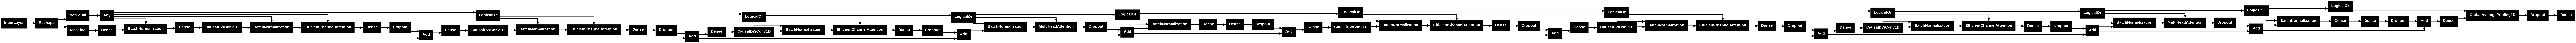

In [ ]:
from tensorflow.keras.utils import plot_model
model.load_weights('./wlasl.h5')
model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
plot_model(model, to_file='architecture.png', rankdir='LR')

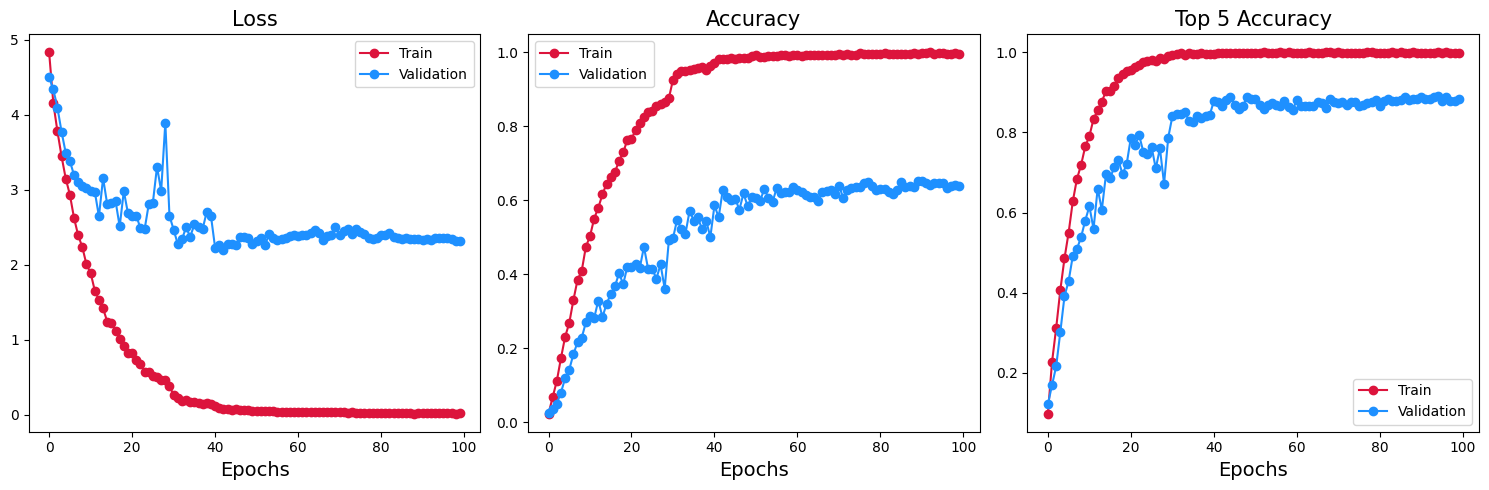

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history['val_accuracy'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.title('Accuracy', fontsize=15)
plt.legend(loc='best')

plt.subplot(1, 3, 3)
plt.plot(history['top5_accuracy'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history['val_top5_accuracy'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.title('Top 5 Accuracy', fontsize=15)
plt.legend(loc='best')

plt.tight_layout()
plt.show()